# Predicting which Subreddit a Reddit Post Belongs to Based on the Post Content

In this code, we will be predicting the subreddit that a Reddit post belongs to based on the content of the post. 

In [ ]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# install seaborn
%pip install seaborn

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print(spark.version)

3.4.0


In [2]:
df = spark.read.csv(f'../df_ml.csv', header = True)

In [3]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [4]:
from pyspark.sql.functions import concat_ws, col, year, month, regexp_replace, when, lit, udf

clean = df \
    .withColumn('num_comments', col('num_comments').cast("integer")) \
    .withColumn('score', col('score').cast("integer")) \
    .withColumn('date', col('date').cast("date")) \
    .withColumn('is_biden', col('is_biden').cast("integer")) \
    .withColumn('is_trump', col('is_trump').cast("integer")) \
    .withColumn('is_hunter', col('is_hunter').cast("integer")) \
    .withColumn('is_border', col('is_border').cast("integer")) \
    .withColumn('is_war', col('is_war').cast("integer")) \
    .withColumn('is_israel', col('is_israel').cast("integer")) \
    .withColumn('is_harris', col('is_harris').cast("integer")) \
    .withColumn('is_indictment', col('is_indictment').cast("integer")) \
    .withColumn("year", year(col("date"))) \
    .withColumn("month", month(col("date"))) \
    .withColumn("clean_text", regexp_replace(col("text"), "[^a-zA-Z0-9\s]", "")) \
    .drop(*['_c0', 'id', 'date'])

In [5]:
clean.show(1)

+----------+------------------+--------------------+------------+-----+---------+--------+--------+---------+---------+------+---------+---------+-------------+----+-----+--------------------+
| subreddit|            author|                text|num_comments|score|sentiment|is_biden|is_trump|is_hunter|is_border|is_war|is_israel|is_harris|is_indictment|year|month|          clean_text|
+----------+------------------+--------------------+------------+-----+---------+--------+--------+---------+---------+------+---------+---------+-------------+----+-----+--------------------+
|Republican|interestingfactoid| say her name   c...|           2|   12| positive|       1|       0|        0|        1|     0|        0|        0|            0|2024|    6| say her name   c...|
+----------+------------------+--------------------+------------+-----+---------+--------+--------+---------+---------+------+---------+---------+-------------+----+-----+--------------------+
only showing top 1 row



In [6]:
clean.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- is_biden: integer (nullable = true)
 |-- is_trump: integer (nullable = true)
 |-- is_hunter: integer (nullable = true)
 |-- is_border: integer (nullable = true)
 |-- is_war: integer (nullable = true)
 |-- is_israel: integer (nullable = true)
 |-- is_harris: integer (nullable = true)
 |-- is_indictment: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- clean_text: string (nullable = true)



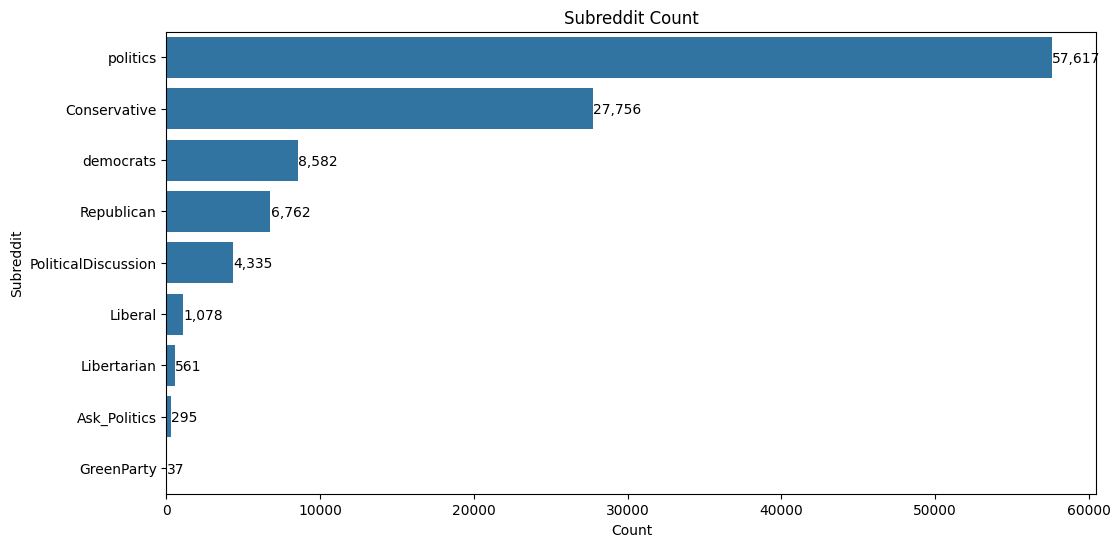

In [26]:
score_df = clean.select('subreddit').toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.countplot(data=score_df, y='subreddit', ax=ax, order=score_df['subreddit'].value_counts().index)
# Add labels
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.title('Subreddit Count')

# Annotations
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', (p.get_width() + 10, p.get_y() + 0.5))

plt.show()

In [27]:
from pyspark.sql.functions import col

reddits = [
    'politics','Conservative', 'democrats', 'Republican', 'PoliticalDiscussion'
    'Liberal', 'Libertarian', 'Ask_Politics', 'GreenParty'
]

vc = clean.select('subreddit').toPandas().groupby('subreddit').value_counts()
vc_norm = vc / vc.sum()

print(vc_norm.sort_values(ascending=False))

subreddit
politics               0.538361
Conservative           0.259346
democrats              0.080188
Republican             0.063183
PoliticalDiscussion    0.040505
Liberal                0.010073
Libertarian            0.005242
Ask_Politics           0.002756
GreenParty             0.000346
Name: count, dtype: float64


In [ ]:
from pyspark.sql.functions import count, col
import numpy as np

# Calculate class distribution
class_distribution = clean.groupBy("subreddit").agg(count("*").alias("class_count"))
class_distribution.show()

# Drop GreenParty, Ask_Politics, and PoliticalDiscussion
clean = clean.filter(col("subreddit") != "GreenParty")
clean = clean.filter(col("subreddit") != "Ask_Politics")
clean = clean.filter(col("subreddit") != "PoliticalDiscussion")

class_distribution = clean.groupBy("subreddit").agg(count("*").alias("class_count"))
class_distribution.show()

# Calculate the median class size
class_sizes = class_distribution.select("class_count").rdd.flatMap(lambda x: x).collect()
median_class_size = int(np.median(class_sizes))
print(f"Median class size: {median_class_size:,}")

+-------------------+-----------+
|          subreddit|class_count|
+-------------------+-----------+
|         Republican|       6762|
|         GreenParty|         37|
|            Liberal|       1078|
|           politics|      57617|
|        Libertarian|        561|
|PoliticalDiscussion|       4335|
|       Ask_Politics|        295|
|          democrats|       8582|
|       Conservative|      27756|
+-------------------+-----------+



+-------------------+-----------+
|          subreddit|class_count|
+-------------------+-----------+
|         Republican|       6762|
|            Liberal|       1078|
|           politics|      57617|
|        Libertarian|        561|
|PoliticalDiscussion|       4335|
|          democrats|       8582|
|       Conservative|      27756|
+-------------------+-----------+

Median class size: 6,762


In [8]:
# Adjust class sizes to the median
balanced_data = spark.createDataFrame([], schema=clean.schema)
excluded_data = spark.createDataFrame([], schema=clean.schema)

for row in class_distribution.collect():
    print(f'Row: {row}')
    subreddit = row["subreddit"]
    class_count = row["class_count"]
    if class_count < median_class_size:
        multiplier = median_class_size // class_count
        remainder = median_class_size % class_count
        minority_data = clean.filter(col("subreddit") == subreddit)

        for _ in range(multiplier):
            balanced_data = balanced_data.union(minority_data)
            
        if remainder > 0:
            fraction = remainder / class_count
            sampled_data = minority_data.sample(fraction, seed=1989)
            balanced_data = balanced_data.union(sampled_data)

    elif class_count > median_class_size:
        diff = class_count - median_class_size
        fraction = diff / class_count
        balanced_data = balanced_data.filter(col("subreddit") != subreddit)
        sampled_data = clean.filter(col("subreddit") == subreddit).sample(1 - fraction, seed=1989)
        balanced_data = balanced_data.union(sampled_data)
        excluded_data = excluded_data.union(clean.filter(col("subreddit") == subreddit).subtract(sampled_data))
    
    else:
        assert class_count == median_class_size
        balanced_data = balanced_data.union(clean.filter(col("subreddit") == subreddit))

# Check final class distribution
balanced_data.groupBy("subreddit").count().show()

Row: Row(subreddit='Republican', class_count=6762)
Row: Row(subreddit='Liberal', class_count=1078)
Row: Row(subreddit='politics', class_count=57617)
Row: Row(subreddit='Libertarian', class_count=561)
Row: Row(subreddit='PoliticalDiscussion', class_count=4335)
Row: Row(subreddit='democrats', class_count=8582)
Row: Row(subreddit='Conservative', class_count=27756)


+-------------------+-----+
|          subreddit|count|
+-------------------+-----+
|         Republican| 6762|
|            Liberal| 6794|
|           politics| 6883|
|        Libertarian| 6771|
|PoliticalDiscussion| 6787|
|          democrats| 6754|
|       Conservative| 6820|
+-------------------+-----+



In [9]:
excluded_data.groupBy("subreddit").count().show()

+------------+-----+
|   subreddit|count|
+------------+-----+
|    politics|49474|
|   democrats| 1737|
|Conservative|20542|
+------------+-----+



In [37]:
# Convert strings to vector embeddings
from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler, CountVectorizer, StopWordsRemover
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
stop_word_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_words")

# hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures", numFeatures=500)
# idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="tfidf")

# Try Counvectorizer instead of HashingTF
cv = CountVectorizer(inputCol=stop_word_remover.getOutputCol(), outputCol="cv", vocabSize=1000)
cv_idf = IDF(inputCol=cv.getOutputCol(), outputCol="tfidf_cv")


subreddit_indexer = StringIndexer(inputCol="subreddit", outputCol="subreddit_index")
subreddit_encoder = OneHotEncoder(inputCol="subreddit_index", outputCol="subreddit_vector")

author_indexer = StringIndexer(inputCol="author", outputCol="author_index")

sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
sentiment_encoder = OneHotEncoder(inputCol="sentiment_index", outputCol="sentiment_vector")

# Normalize all input features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Assemble all features into a single vector
# assembler = VectorAssembler(
#     inputCols=[
#         "tfidf", "num_comments", "score", "author_index",
#         "sentiment_vector", "year", "month", "is_biden", "is_trump", "is_hunter", 
#         "is_border", "is_war", "is_israel", "is_harris",
#         "is_indictment"
#     ],
#     outputCol="features",
# )

assembler = VectorAssembler(
    inputCols=[
        "tfidf_cv", "num_comments", "score", "author_index",
        "sentiment_vector", "year", "month", "is_biden", "is_trump", "is_hunter", 
        "is_border", "is_war", "is_israel", "is_harris",
        "is_indictment"
    ],
    outputCol="features",
)

# Build the pipeline
pipeline = Pipeline(
    stages=[
        tokenizer,
        stop_word_remover,
        cv,
        cv_idf,
        subreddit_indexer,
        subreddit_encoder,
        author_indexer,
        sentiment_indexer,
        sentiment_encoder,
        assembler,
        scaler
    ]
)

In [38]:
pipeline_model = pipeline.fit(balanced_data)

In [39]:
modeling_df = pipeline_model.transform(balanced_data)

In [40]:
# Split data into training, validation, and test sets
(train, test) = modeling_df.randomSplit([0.8, 0.2], seed=1989)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [41]:
train_subreddit_df = train.select('subreddit').toPandas()
test_subreddit_df = test.select('subreddit').toPandas()

In [42]:
subreddit_map = {
    'politics': 0,
    'Conservative': 1,
    'Liberal': 2,
    'PoliticalDiscussion': 3,
    'Libertarian': 4,
    'Republican': 5,
    'democrats': 6
}

train_subreddit_df['subreddit_num'] = train_subreddit_df['subreddit'].apply(lambda x: subreddit_map[x])
test_subreddit_df['subreddit_num'] = test_subreddit_df['subreddit'].apply(lambda x: subreddit_map[x])

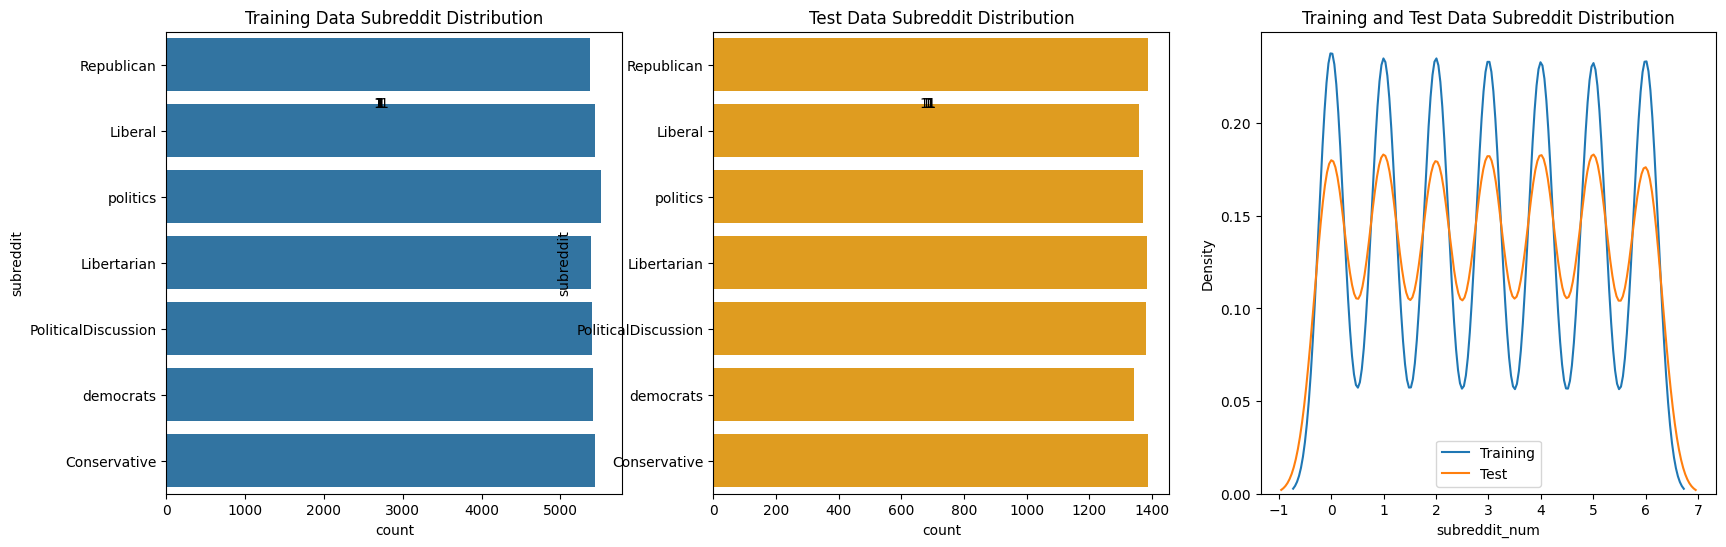

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.countplot(data=train_subreddit_df, y='subreddit', ax=ax[0])
sns.countplot(data=test_subreddit_df, y='subreddit', ax=ax[1], color='orange')
# Write couts on top of bars
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for p in ax[1].patches:
    ax[1].annotate(f"{p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[0].set_title('Training Data Subreddit Distribution')
ax[1].set_title('Test Data Subreddit Distribution')

# Plot normalized score distribution for training and test
sns.kdeplot(data=train_subreddit_df, x='subreddit_num', ax=ax[2], label='Training')
sns.kdeplot(data=test_subreddit_df, x='subreddit_num', ax=ax[2], label='Test')

ax[2].set_title('Training and Test Data Subreddit Distribution')
ax[2].legend()

plt.show()

In [44]:
# Convert subreddit index to integer
train = train.withColumn("label", train["subreddit_index"].cast("integer"))
test = test.withColumn("label", test["subreddit_index"].cast("integer"))

In [40]:
# Get accuracy if all predictions were the most common class
from pyspark.sql.functions import lit

most_common_class = train.groupBy('label').count().orderBy('count', ascending=False).first()['label']
most_common_class

predictions = test.withColumn('prediction', lit(most_common_class).cast("double"))
acc = evaluator.evaluate(predictions)

print(f"Most common class accuracy (baseline model): {acc:.2%}")

# Evaluate a random model with equal probability for each class
from pyspark.sql.functions import rand

predictions = test.withColumn('prediction', rand() * 7)
acc = evaluator.evaluate(predictions)

print(f"Random model accuracy: {acc:.2%}")

Most common class accuracy (baseline model): 14.28%


Random model accuracy: 0.00%


### Logistic Regression

In [56]:
lr = LogisticRegression(labelCol="label", featuresCol="scaled_features")

lr_model = lr.fit(train)
lr_preds = lr_model.transform(test)
lr_acc = evaluator.evaluate(lr_preds)
print(f"Lr Model Accuracy: {lr_acc:.2%}")

Lr Model Accuracy: 47.98%


In [57]:
# Hypertune logistic classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr = LogisticRegression(labelCol="label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_lr_model")

In [58]:
predictions = best_model.transform(test)
acc = evaluator.evaluate(predictions)

print(f"Best model accuracy: {acc:.2%}")

Best model accuracy: 47.92%


In [59]:
# Visualize cross validation results
import seaborn as sns
import pandas as pd

cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
# Extract hyperparameters
paramGrid = cvModel.getEstimatorParamMaps()

for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results

,accuracy,regParam,elasticNetParam
0,0.473784,0.0,0.0
1,0.474099,0.0,0.5
2,0.473703,0.0,1.0
3,0.428311,0.1,0.0
4,0.249209,0.1,0.5
5,0.162957,0.1,1.0


In [63]:
cv_results.to_csv('lr_cv_results.csv', index=False)

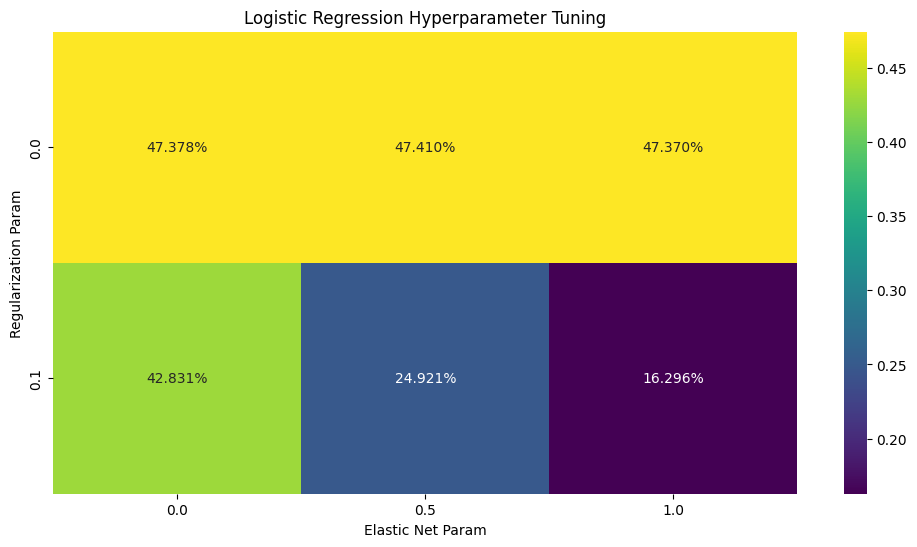

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

heatmap_data = cv_results.pivot(index="regParam", columns="elasticNetParam", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Logistic Regression Hyperparameter Tuning")

ax.set_xlabel("Elastic Net Param")
ax.set_ylabel("Regularization Param")

plt.show()

### Random Forest Classifier

In [45]:
# Run basic Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")

rf_model = rf.fit(train)
rf_preds = rf_model.transform(test)
rf_acc = evaluator.evaluate(rf_preds)

print(f"Random Forest Model Accuracy: {rf_acc:.2%}")

Random Forest Model Accuracy: 44.22%


In [48]:
# Hypertune Random Forest Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_rf_model")

predictions = best_model.transform(test)
rf_best_acc = evaluator.evaluate(predictions)
print(f"Best Random Forest model accuracy: {rf_best_acc:.2%}")

Best Random Forest model accuracy: 51.26%


   accuracy  numTrees  maxDepth
0  0.336057      10.0       5.0
1  0.442706      10.0      10.0
2  0.417748      20.0       5.0
3  0.496420      20.0      10.0
4  0.450108      30.0       5.0
5  0.516918      30.0      10.0


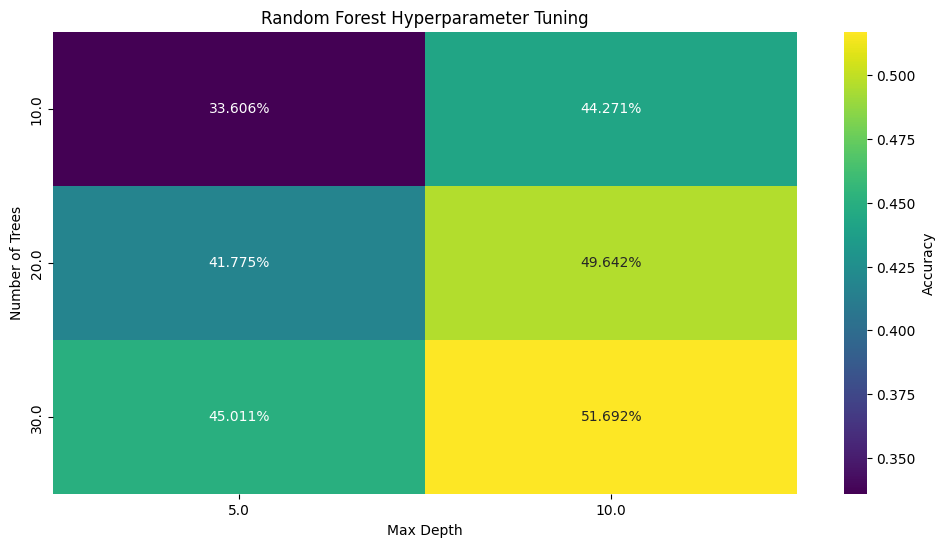

In [49]:
import seaborn as sns
import pandas as pd

cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
# Extract hyperparameters
paramGrid = cvModel.getEstimatorParamMaps()

for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("rf_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

heatmap_data = cv_results.pivot(index="numTrees", columns="maxDepth", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Random Forest Hyperparameter Tuning")

ax.set_xlabel("Max Depth")
ax.set_ylabel("Number of Trees")

ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

### Decision Tree Classifier

In [46]:
# Run basic Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")

dt_model = dt.fit(train)
dt_preds = dt_model.transform(test)
dt_acc = evaluator.evaluate(dt_preds)

print(f"Decision Tree Model Accuracy: {dt_acc:.2%}")

Decision Tree Model Accuracy: 47.37%


In [50]:
# Hypertune Decision Tree Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_dt_model")

In [51]:
dt_best_preds = best_model.transform(test)
dt_best_acc = evaluator.evaluate(dt_best_preds)
print(f"Best Decision Tree model accuracy: {dt_best_acc:.2%}")

Best Decision Tree model accuracy: 57.35%


   accuracy  maxDepth  maxBins
0  0.483633       5.0     10.0
1  0.467289       5.0     20.0
2  0.473965       5.0     30.0
3  0.576216      10.0     10.0
4  0.575009      10.0     20.0
5  0.574444      10.0     30.0


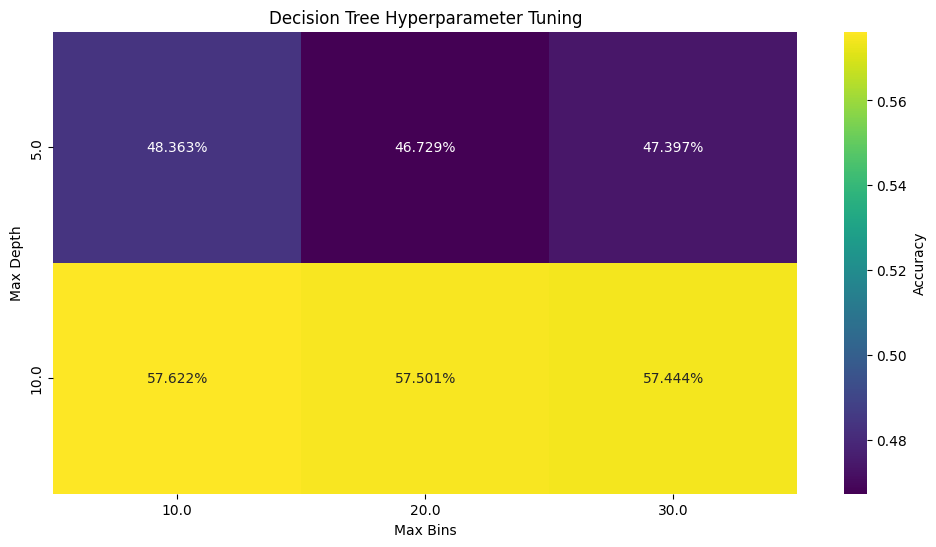

In [52]:
cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
paramGrid = cvModel.getEstimatorParamMaps()
for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("dt_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
heatmap_data = cv_results.pivot(index="maxDepth", columns="maxBins", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")
plt.title("Decision Tree Hyperparameter Tuning")
ax.set_xlabel("Max Bins")
ax.set_ylabel("Max Depth")
ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

### Naive Bayes Classifier

In [47]:
# Run basic Multinomial Naive Bayes Classifier
nb = NaiveBayes(labelCol="label", featuresCol="scaled_features")

nb_model = nb.fit(train)
nb_preds = nb_model.transform(test)
nb_acc = evaluator.evaluate(nb_preds)

print(f"Naive Bayes Model Accuracy: {nb_acc:.2%}")

Naive Bayes Model Accuracy: 32.65%


In [53]:
# Hypertune Naive Bayes Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

nb = NaiveBayes(labelCol="label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_nb_model")

In [54]:
# Evaluate best model
nb_best_preds = best_model.transform(test)
nb_best_acc = evaluator.evaluate(nb_best_preds)
print(f"Best Naive Bayes model accuracy: {nb_best_acc:.2%}")

Best Naive Bayes model accuracy: 32.65%


   accuracy  smoothing
0  0.317279        0.0
1  0.317331        0.5
2  0.317463        1.0


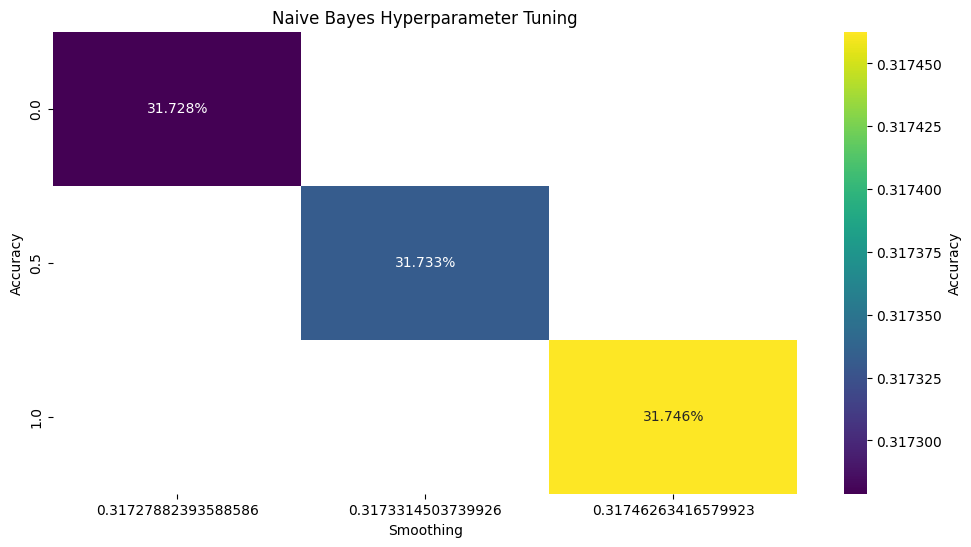

In [55]:
# Visualize cross validation results
cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
paramGrid = cvModel.getEstimatorParamMaps()
for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("nb_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
heatmap_data = cv_results.pivot(index="smoothing", columns="accuracy", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Naive Bayes Hyperparameter Tuning")
ax.set_xlabel("Smoothing")
ax.set_ylabel("Accuracy")
ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

## Assessing Results

In [64]:
lr_cv_results = pd.read_csv("lr_cv_results.csv")
rf_cv_results = pd.read_csv("rf_cv_results.csv")
dt_cv_results = pd.read_csv("dt_cv_results.csv")
nb_cv_results = pd.read_csv("nb_cv_results.csv")

print("Logistic Regression Best Hyperparameters")
print(lr_cv_results.loc[lr_cv_results["accuracy"].idxmax()])
print("\nRandom Forest Best Hyperparameters")
print(rf_cv_results.loc[rf_cv_results["accuracy"].idxmax()])
print("\nDecision Tree Best Hyperparameters")
print(dt_cv_results.loc[dt_cv_results["accuracy"].idxmax()])
print("\nNaive Bayes Best Hyperparameters")
print(nb_cv_results.loc[nb_cv_results["accuracy"].idxmax()])

Logistic Regression Best Hyperparameters
accuracy           0.474099
regParam           0.000000
elasticNetParam    0.500000
Name: 1, dtype: float64

Random Forest Best Hyperparameters
Unnamed: 0     5.000000
accuracy       0.516918
numTrees      30.000000
maxDepth      10.000000
Name: 5, dtype: float64

Decision Tree Best Hyperparameters
Unnamed: 0     3.000000
accuracy       0.576216
maxDepth      10.000000
maxBins       10.000000
Name: 3, dtype: float64

Naive Bayes Best Hyperparameters
Unnamed: 0    2.000000
accuracy      0.317463
smoothing     1.000000
Name: 2, dtype: float64


In [135]:
train

DataFrame[subreddit: string, author: string, text: string, num_comments: int, score: int, sentiment: string, is_biden: int, is_trump: int, is_hunter: int, is_border: int, is_war: int, is_israel: int, is_harris: int, is_indictment: int, year: int, month: int, clean_text: string, words: array<string>, filtered_words: array<string>, cv: vector, tfidf_cv: vector, subreddit_index: double, subreddit_vector: vector, author_index: double, sentiment_index: double, sentiment_vector: vector, features: vector, scaled_features: vector, label: int]

In [139]:
train = train.filter(col("subreddit") != "PoliticalDiscussion")
test = test.filter(col("subreddit") != "PoliticalDiscussion")

In [140]:
# Load best models
best_lr = LogisticRegression(labelCol="label", featuresCol="scaled_features", regParam=0.0, elasticNetParam=0.5)
best_rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=30, maxDepth=10)
best_dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features", maxDepth=10, maxBins=10)
best_nb = NaiveBayes(labelCol="label", featuresCol="scaled_features", smoothing=1.0)

# Train best models
best_lr_model = best_lr.fit(train)
best_rf_model = best_rf.fit(train)
best_dt_model = best_dt.fit(train)
best_nb_model = best_nb.fit(train)

In [149]:
lr_preds = best_lr_model.transform(test)
rf_preds = best_rf_model.transform(test)
dt_preds = best_dt_model.transform(test)
nb_preds = best_nb_model.transform(test)

In [150]:
lr_preds.toPandas().to_csv("lr_preds.csv", index=False)
rf_preds.toPandas().to_csv("rf_preds.csv", index=False)
dt_preds.toPandas().to_csv("dt_preds.csv", index=False)
nb_preds.toPandas().to_csv("nb_preds.csv", index=False)

# Final Reporting

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
lr_pred_df = pd.read_csv("../../../data/models/subreddit-pred/results/lr_preds.csv")
rf_pred_df = pd.read_csv("../../../data/models/subreddit-pred/results/rf_preds.csv")
dt_pred_df = pd.read_csv("../../../data/models/subreddit-pred/results/dt_preds.csv")
nb_pred_df = pd.read_csv("../../../data/models/subreddit-pred/results/nb_preds.csv")

In [41]:
lr_pred_df.rename(columns={"prediction": "lr_prediction", "rawPrediction": "lr_rawPrediction", "probability": "lr_probability"}, inplace=True)
rf_pred_df.rename(columns={"prediction": "rf_prediction", "rawPrediction": "rf_rawPrediction", "probability": "rf_probability"}, inplace=True)
dt_pred_df.rename(columns={"prediction": "dt_prediction", "rawPrediction": "dt_rawPrediction", "probability": "dt_probability"}, inplace=True)
nb_pred_df.rename(columns={"prediction": "nb_prediction", "rawPrediction": "nb_rawPrediction", "probability": "nb_probability"}, inplace=True)

In [42]:
# Combine all predictions (all rows match exactly except for the prediction columns)
combined_preds = pd.concat([lr_pred_df, rf_pred_df, dt_pred_df, nb_pred_df], axis=1)

In [43]:
# Select only the columns we want to keep
combined_preds = combined_preds[[
    "label", "lr_prediction", "lr_probability", "rf_prediction", "rf_probability",
    "dt_prediction", "dt_probability", "nb_prediction", "nb_probability"
]]

In [44]:
combined_preds = combined_preds.loc[:, ~combined_preds.columns.duplicated()]

In [45]:
# Convert all prediction columns to integers
combined_preds["lr_prediction"] = combined_preds["lr_prediction"].astype(int)
combined_preds["rf_prediction"] = combined_preds["rf_prediction"].astype(int)
combined_preds["dt_prediction"] = combined_preds["dt_prediction"].astype(int)
combined_preds["nb_prediction"] = combined_preds["nb_prediction"].astype(int)

In [46]:
color_map = {
    "Conservative": "pink",
    "Republican": "red",
    "democrats": "blue",
    "Liberal": "skyblue",
    "Libertarian": "gold",
    "politics": "green"
}

# Create map from subreddit to index based on model
subreddit_map = {
    'politics': 0,
    'Conservative': 1,
    'Liberal': 2,
    'Libertarian': 4,
    'Republican': 5,
    'democrats': 6
}

In [47]:
from sklearn.metrics import classification_report

print("Logistic Regression Classification Report")
print(classification_report(combined_preds["label"], combined_preds["lr_prediction"], labels=[0, 1, 2, 4, 5, 6], target_names=list(subreddit_map.keys())))

Logistic Regression Classification Report
              precision    recall  f1-score   support

    politics       0.49      0.49      0.49      1372
Conservative       0.33      0.25      0.28      1386
     Liberal       0.55      0.65      0.60      1359
 Libertarian       0.72      0.91      0.80      1384
  Republican       0.35      0.33      0.34      1386
   democrats       0.36      0.29      0.32      1343

    accuracy                           0.49      8230
   macro avg       0.46      0.49      0.47      8230
weighted avg       0.46      0.49      0.47      8230



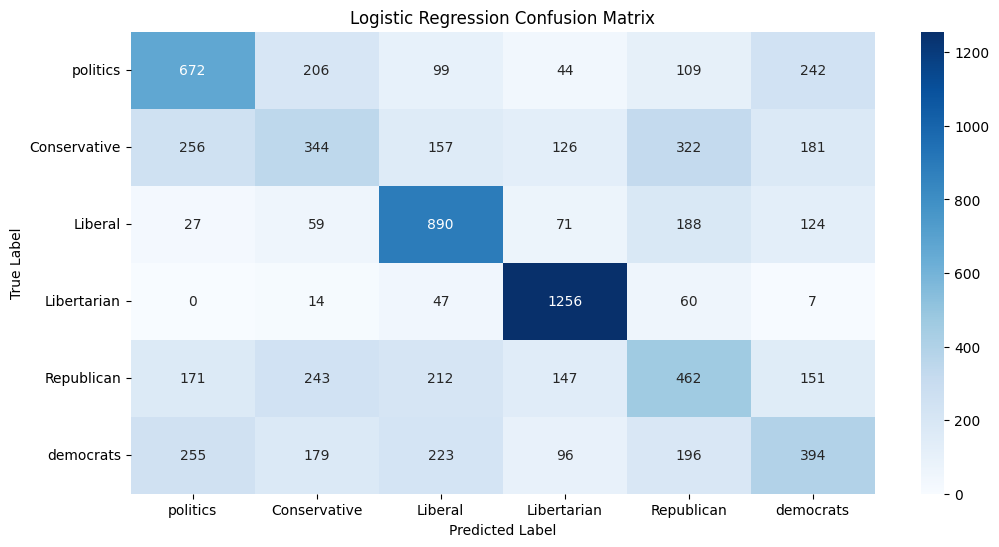

In [48]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

lr_confusion_matrix = confusion_matrix(combined_preds["label"], combined_preds["lr_prediction"])

import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(lr_confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt=".0f")
# Add labels for tick labels
ax.set_xticklabels(list(subreddit_map.keys()))
ax.set_yticklabels(list(subreddit_map.keys()), rotation=0)

plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [49]:
print("Random Forest Classification Report")
print(classification_report(combined_preds["label"], combined_preds["rf_prediction"],labels=[0, 1, 2, 4, 5, 6], target_names=list(subreddit_map.keys())))

Random Forest Classification Report
              precision    recall  f1-score   support

    politics       0.43      0.74      0.54      1372
Conservative       0.43      0.35      0.39      1386
     Liberal       0.54      0.56      0.55      1359
 Libertarian       0.65      0.66      0.65      1384
  Republican       0.49      0.57      0.53      1386
   democrats       0.43      0.10      0.16      1343

    accuracy                           0.50      8230
   macro avg       0.49      0.49      0.47      8230
weighted avg       0.49      0.50      0.47      8230



In [50]:
combined_preds["label"]

0       5
1       5
2       5
3       5
4       5
       ..
8225    1
8226    1
8227    1
8228    1
8229    1
Name: label, Length: 8230, dtype: int64

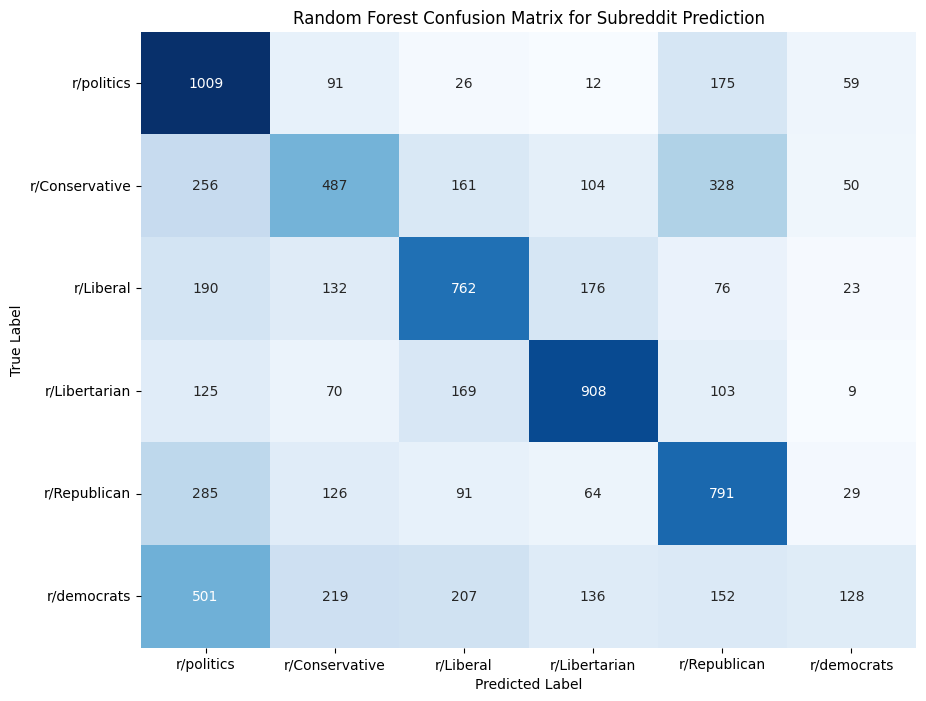

In [51]:
# Plot confusion matrix
rf_confusion_matrix = confusion_matrix(combined_preds["label"], combined_preds["rf_prediction"])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(rf_confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt=".0f")

plt.title("Random Forest Confusion Matrix for Subreddit Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

ax.set_xticklabels(['r/' + key for key in subreddit_map.keys()])
ax.set_yticklabels(['r/' + key for key in subreddit_map.keys()], rotation=0)
# Hide colorbar
ax.collections[0].colorbar.remove()

plt.show()

# Save fig
fig.savefig("rf_confusion_matrix.png", bbox_inches="tight", dpi=300)



In [52]:
print("Decision Tree Classification Report")
print(classification_report(combined_preds["label"], combined_preds["dt_prediction"], labels=[0, 1, 2, 4, 5, 6], target_names=list(subreddit_map.keys())))

Decision Tree Classification Report
              precision    recall  f1-score   support

    politics       0.53      0.75      0.62      1372
Conservative       0.45      0.46      0.45      1386
     Liberal       0.58      0.62      0.60      1359
 Libertarian       0.69      0.66      0.68      1384
  Republican       0.74      0.50      0.60      1386
   democrats       0.43      0.38      0.41      1343

    accuracy                           0.56      8230
   macro avg       0.57      0.56      0.56      8230
weighted avg       0.57      0.56      0.56      8230



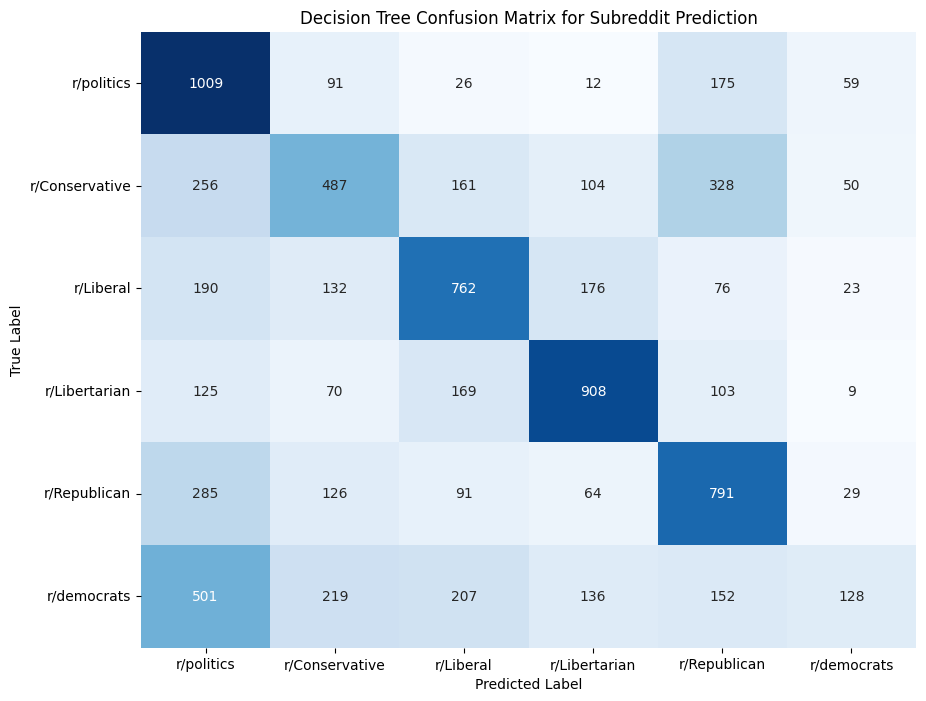

In [53]:
# Plot confusion matrix
dt_confusion_matrix = confusion_matrix(combined_preds["label"], combined_preds["rf_prediction"])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(rf_confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt=".0f")

plt.title("Decision Tree Confusion Matrix for Subreddit Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

ax.set_xticklabels(['r/' + key for key in subreddit_map.keys()])
ax.set_yticklabels(['r/' + key for key in subreddit_map.keys()], rotation=0)
# Hide colorbar
ax.collections[0].colorbar.remove()

plt.show()

# Save fig
fig.savefig("dt_confusion_matrix.png", bbox_inches='tight', dpi=300)

In [54]:
print("Naive Bayes Classification Report")
print(classification_report(combined_preds["label"], combined_preds["nb_prediction"], labels=[0, 1, 2, 4, 5, 6], target_names=list(subreddit_map.keys())))

Naive Bayes Classification Report
              precision    recall  f1-score   support

    politics       0.30      0.49      0.37      1372
Conservative       0.26      0.27      0.26      1386
     Liberal       0.48      0.26      0.34      1359
 Libertarian       0.12      0.15      0.13      1384
  Republican       0.15      0.12      0.13      1386
   democrats       0.00      0.00      0.00      1343

   micro avg       0.25      0.21      0.23      8230
   macro avg       0.22      0.21      0.21      8230
weighted avg       0.22      0.21      0.21      8230



/Users/mariongeary/anaconda3/envs/bigdata/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariongeary/anaconda3/envs/bigdata/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariongeary/anaconda3/envs/bigdata/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

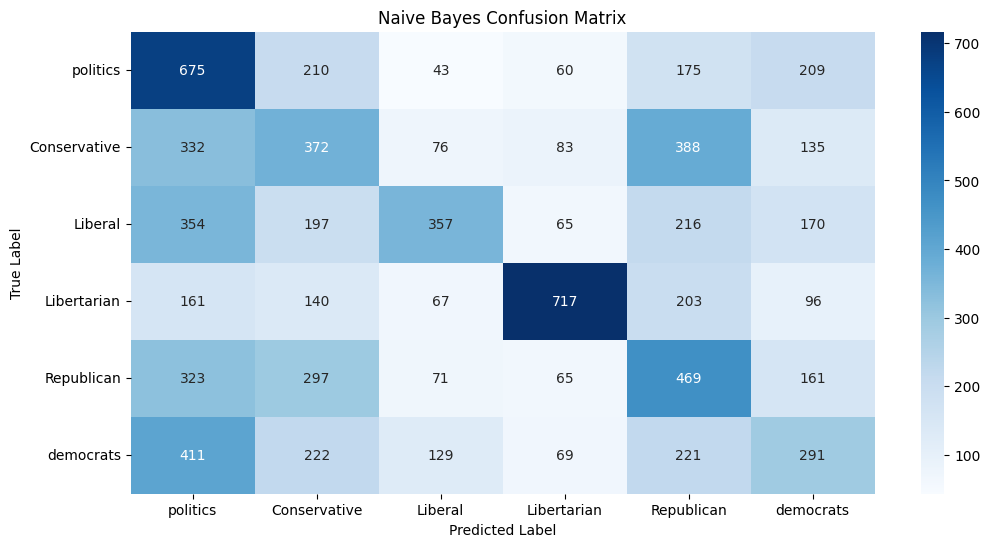

In [55]:
# Plot confusion matrix

nb_confusion_matrix = confusion_matrix(combined_preds["label"], combined_preds["nb_prediction"])
nb_confusion_matrix = nb_confusion_matrix[~np.all(nb_confusion_matrix == 0, axis=1)]
nb_confusion_matrix = nb_confusion_matrix[:, ~np.all(nb_confusion_matrix == 0, axis=0)]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(nb_confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt=".0f")

plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

ax.set_xticklabels(list(subreddit_map.keys()))
ax.set_yticklabels(list(subreddit_map.keys()), rotation=0)

plt.show()

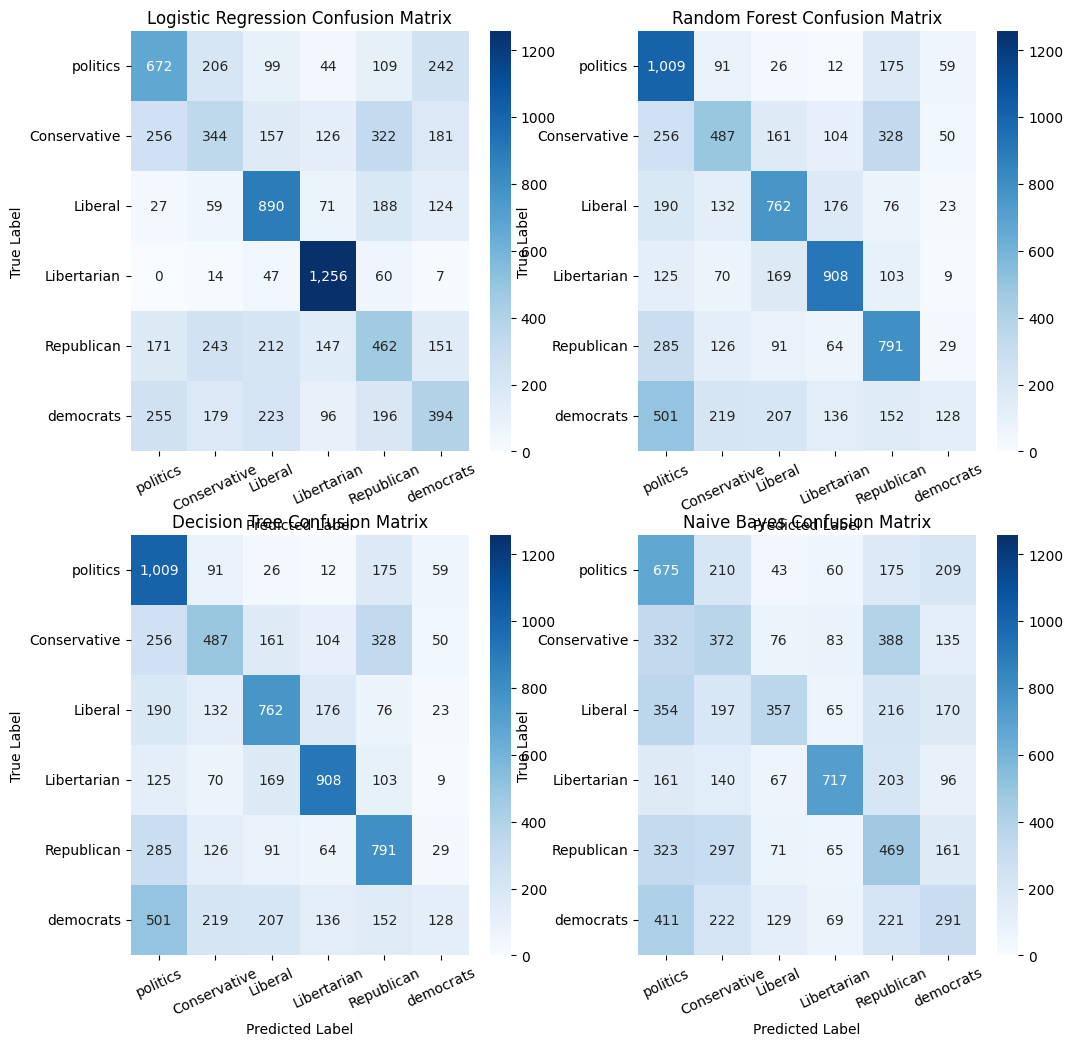

In [56]:
# Plot all confusion matrices

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

vmin = min(lr_confusion_matrix.min(), rf_confusion_matrix.min(), dt_confusion_matrix.min(), nb_confusion_matrix.min())
vmax = max(lr_confusion_matrix.max(), rf_confusion_matrix.max(), dt_confusion_matrix.max(), nb_confusion_matrix.max())

sns.heatmap(lr_confusion_matrix, annot=True, ax=ax[0, 0], cmap="Blues", fmt=",.0f", vmin=vmin, vmax=vmax)
sns.heatmap(rf_confusion_matrix, annot=True, ax=ax[0, 1], cmap="Blues", fmt=",.0f", vmin=vmin, vmax=vmax)
sns.heatmap(dt_confusion_matrix, annot=True, ax=ax[1, 0], cmap="Blues", fmt=",.0f", vmin=vmin, vmax=vmax)
sns.heatmap(nb_confusion_matrix, annot=True, ax=ax[1, 1], cmap="Blues", fmt=",.0f", vmin=vmin, vmax=vmax)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Predicted Label")
        ax[i, j].set_ylabel("True Label")
        ax[i, j].set_xticklabels(list(subreddit_map.keys()), rotation=25)
        ax[i, j].set_yticklabels(list(subreddit_map.keys()), rotation=0)

ax[0, 0].set_title("Logistic Regression Confusion Matrix")
ax[0, 1].set_title("Random Forest Confusion Matrix")
ax[1, 0].set_title("Decision Tree Confusion Matrix")
ax[1, 1].set_title("Naive Bayes Confusion Matrix")

plt.show()

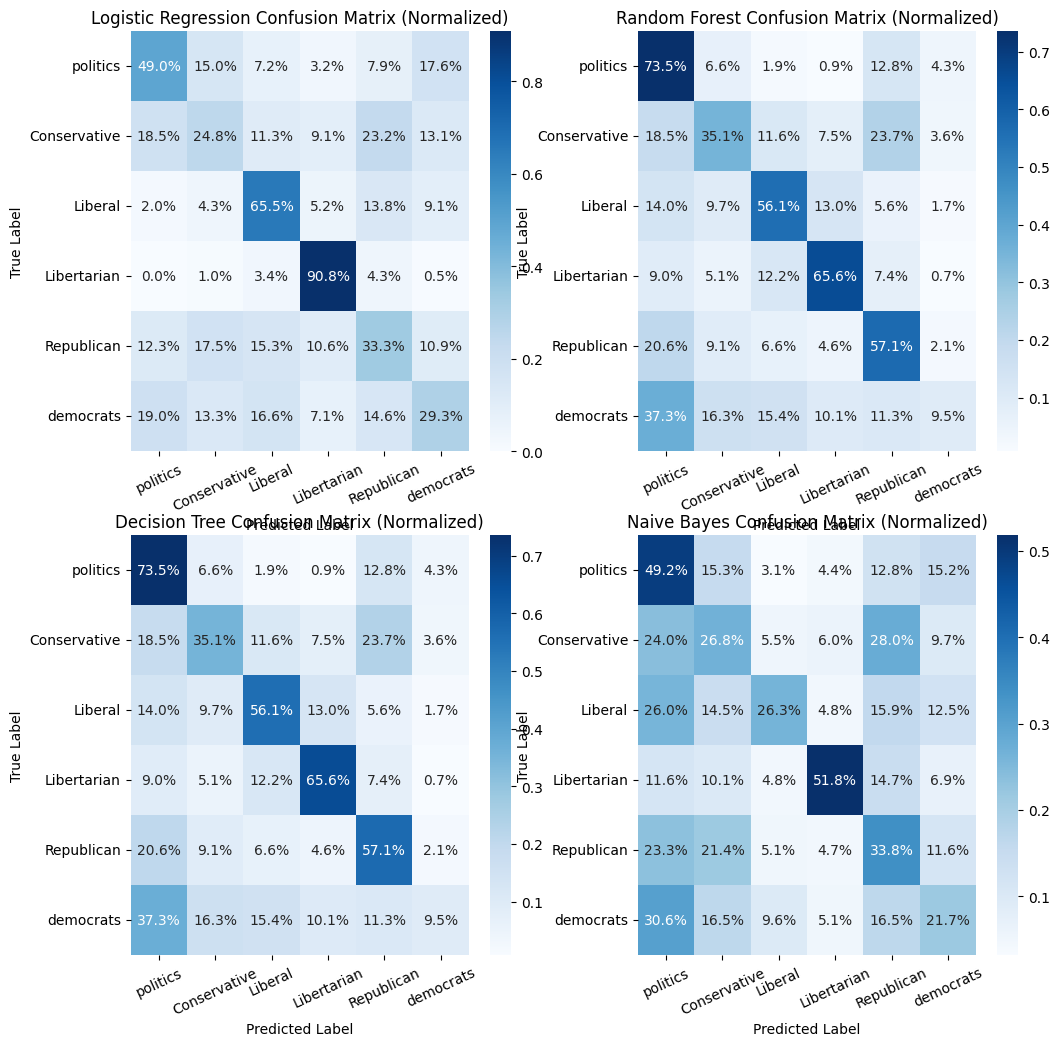

In [57]:
# Row-wise normalization of confusion matrices
lr_confusion_matrix_norm = lr_confusion_matrix / lr_confusion_matrix.sum(axis=1)[:, None]
rf_confusion_matrix_norm = rf_confusion_matrix / rf_confusion_matrix.sum(axis=1)[:, None]
dt_confusion_matrix_norm = dt_confusion_matrix / dt_confusion_matrix.sum(axis=1)[:, None]
nb_confusion_matrix_norm = nb_confusion_matrix / nb_confusion_matrix.sum(axis=1)[:, None]

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.heatmap(lr_confusion_matrix_norm, annot=True, ax=ax[0, 0], cmap="Blues", fmt=".1%")
sns.heatmap(rf_confusion_matrix_norm, annot=True, ax=ax[0, 1], cmap="Blues", fmt=".1%")
sns.heatmap(dt_confusion_matrix_norm, annot=True, ax=ax[1, 0], cmap="Blues", fmt=".1%")
sns.heatmap(nb_confusion_matrix_norm, annot=True, ax=ax[1, 1], cmap="Blues", fmt=".1%")

ax[0, 0].set_title("Logistic Regression Confusion Matrix (Normalized)")
ax[0, 1].set_title("Random Forest Confusion Matrix (Normalized)")
ax[1, 0].set_title("Decision Tree Confusion Matrix (Normalized)")
ax[1, 1].set_title("Naive Bayes Confusion Matrix (Normalized)")

# Set axis labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Predicted Label")
        ax[i, j].set_ylabel("True Label")
        ax[i, j].set_xticklabels(list(subreddit_map.keys()), rotation=25)
        ax[i, j].set_yticklabels(list(subreddit_map.keys()), rotation=0)

plt.show()

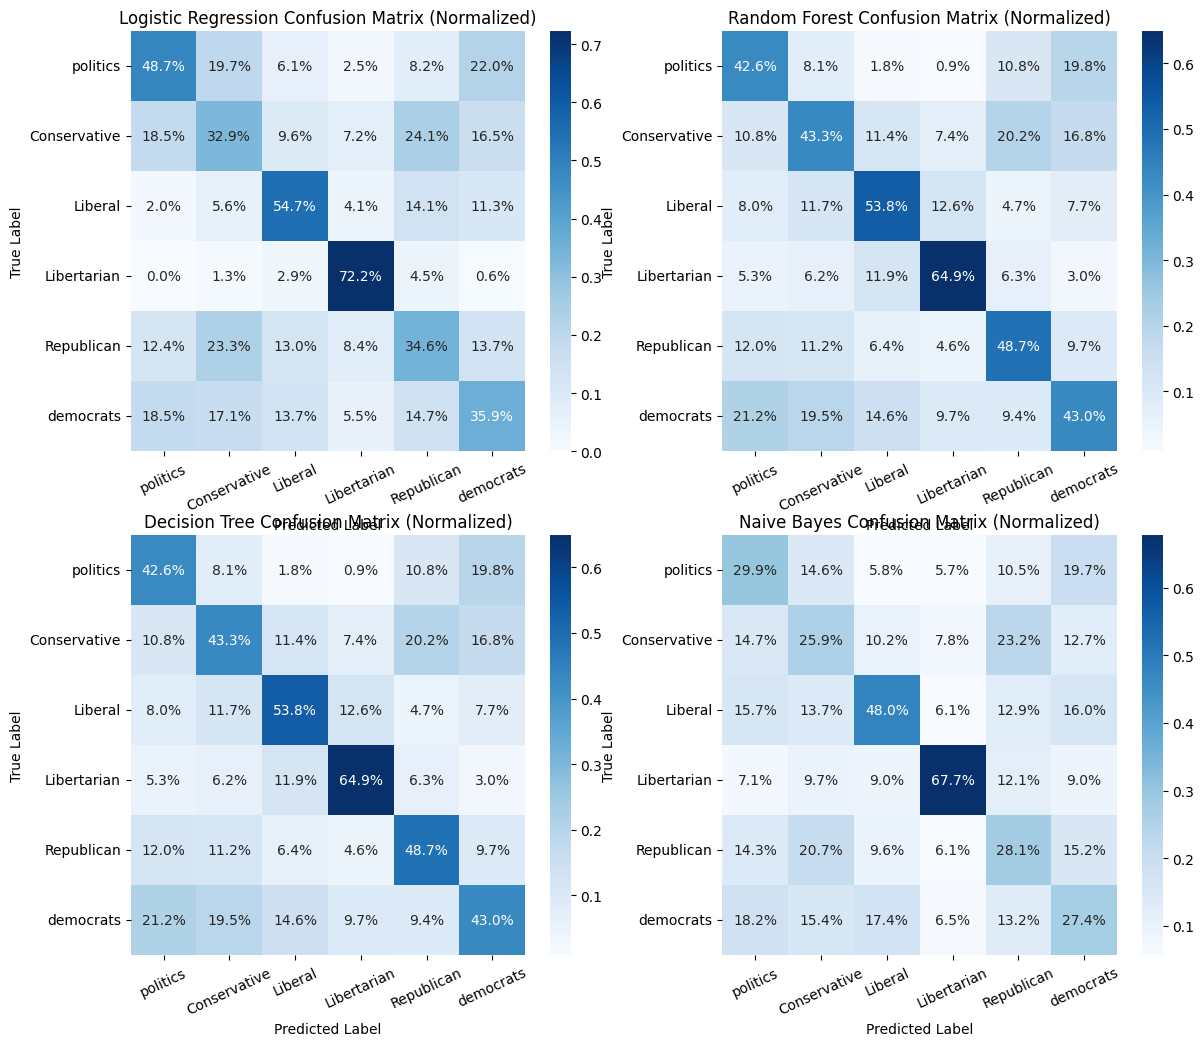

In [58]:
# # Column-wise normalization of confusion matrices
lr_confusion_matrix_norm = lr_confusion_matrix / lr_confusion_matrix.sum(axis=0)
rf_confusion_matrix_norm = rf_confusion_matrix / rf_confusion_matrix.sum(axis=0)
dt_confusion_matrix_norm = dt_confusion_matrix / dt_confusion_matrix.sum(axis=0)
nb_confusion_matrix_norm = nb_confusion_matrix / nb_confusion_matrix.sum(axis=0)

fig, ax = plt.subplots(2, 2, figsize=(14, 12))

sns.heatmap(lr_confusion_matrix_norm, annot=True, ax=ax[0, 0], cmap="Blues", fmt=".1%")
sns.heatmap(rf_confusion_matrix_norm, annot=True, ax=ax[0, 1], cmap="Blues", fmt=".1%")
sns.heatmap(dt_confusion_matrix_norm, annot=True, ax=ax[1, 0], cmap="Blues", fmt=".1%")
sns.heatmap(nb_confusion_matrix_norm, annot=True, ax=ax[1, 1], cmap="Blues", fmt=".1%")

ax[0, 0].set_title("Logistic Regression Confusion Matrix (Normalized)")
ax[0, 1].set_title("Random Forest Confusion Matrix (Normalized)")
ax[1, 0].set_title("Decision Tree Confusion Matrix (Normalized)")
ax[1, 1].set_title("Naive Bayes Confusion Matrix (Normalized)")

# Set axis labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Predicted Label")
        ax[i, j].set_ylabel("True Label")
        ax[i, j].set_xticklabels(list(subreddit_map.keys()), rotation=25)
        ax[i, j].set_yticklabels(list(subreddit_map.keys()), rotation=0)

plt.show()

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import ast

combined_preds['lr_probability'] = combined_preds['lr_probability'].apply(ast.literal_eval)
combined_preds['rf_probability'] = combined_preds['rf_probability'].apply(ast.literal_eval)
combined_preds['dt_probability'] = combined_preds['dt_probability'].apply(ast.literal_eval)
combined_preds['nb_probability'] = combined_preds['nb_probability'].apply(ast.literal_eval)

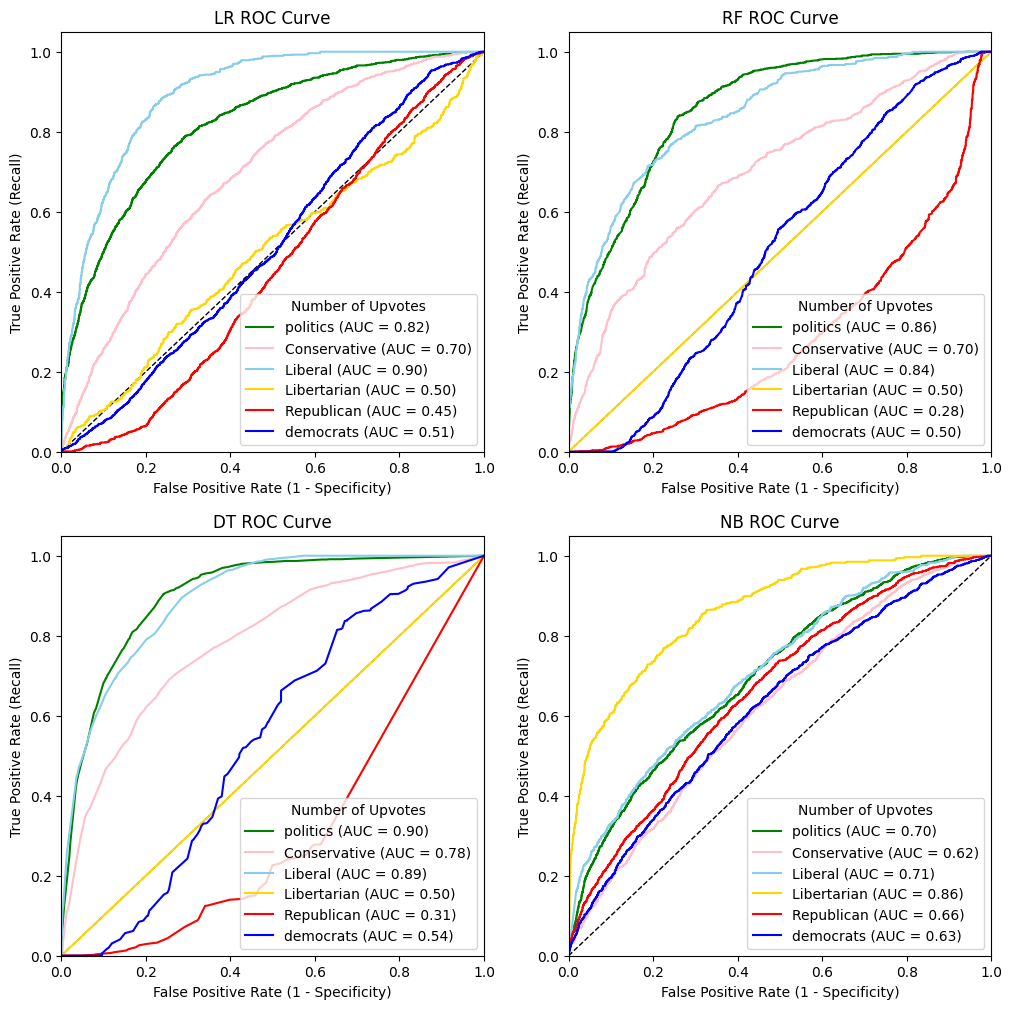

In [60]:
# Plot ROC curves
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

y_true = label_binarize(combined_preds["label"], classes=[0, 1, 2, 4, 5, 6])
lr_probs = np.array(combined_preds["lr_probability"].tolist())
rf_probs = np.array(combined_preds["rf_probability"].tolist())
dt_probs = np.array(combined_preds["dt_probability"].tolist())
nb_probs = np.array(combined_preds["nb_probability"].tolist())

fpr = dict()
tpr = dict()
roc_auc = dict()

models = ["lr", "rf", "dt", "nb"]
probs = [lr_probs, rf_probs, dt_probs, nb_probs]
class_names = list(subreddit_map.keys())

for i, model in enumerate(models):

    ax[i // 2, i % 2].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax[i // 2, i % 2].set_xlim([0.0, 1.0])
    ax[i // 2, i % 2].set_ylim([0.0, 1.05])

    fpr[model] = dict()
    tpr[model] = dict()
    roc_auc[model] = dict()
    for j in range(len(class_names)):
        fpr[model][j], tpr[model][j], _ = roc_curve(y_true[:, j], probs[i][:, j])
        roc_auc[model][j] = roc_auc_score(y_true[:, j], probs[i][:, j])
        ax[i // 2, i % 2].plot(fpr[model][j], tpr[model][j], label=f'{class_names[j]} (AUC = {roc_auc[model][j]:.2f})', color=color_map[class_names[j]])

    ax[i // 2, i % 2].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[i // 2, i % 2].set_ylabel('True Positive Rate (Recall)')

    ax[i // 2, i % 2].set_title(f"{model.upper()} ROC Curve")
    ax[i // 2, i % 2].legend(title="Number of Upvotes")

plt.show()

In [61]:
# Make table of AUC scores
auc_scores = pd.DataFrame(index=class_names, columns=models)

for i, model in enumerate(models):
    for j in range(6):
        auc_scores.loc[class_names[j], model] = roc_auc[model][j]

auc_scores
auc_scores.to_csv("auc_scores.csv")

In [73]:
# Make table of classification reports
from sklearn.metrics import classification_report

precisions = pd.DataFrame(index=class_names, columns=models)
recalls = pd.DataFrame(index=class_names, columns=models)
f1_scores = pd.DataFrame(index=class_names, columns=models)
supports = pd.DataFrame(index=class_names, columns=models)
overall_metrics = pd.DataFrame(index=["accuracy", "precision", "recall", "f1-score", "support"], columns=models)

for model in models:
    preds = combined_preds[f"{model}_prediction"]
    report = classification_report(combined_preds["label"], preds, output_dict=True)
    for j, elem in enumerate([0, 1, 2, 4, 5, 6]):
        f1_scores.loc[class_names[j], model] = report[str(elem)]["f1-score"]
        precisions.loc[class_names[j], model] = report[str(elem)]["precision"]
        recalls.loc[class_names[j], model] = report[str(elem)]["recall"]
        supports.loc[class_names[j], model] = report[str(elem)]["support"]
    overall_metrics.loc["precision", model] = report["macro avg"]["precision"]
    overall_metrics.loc["recall", model] = report["macro avg"]["recall"]
    overall_metrics.loc["f1-score", model] = report["macro avg"]["f1-score"]
    overall_metrics.loc["support", model] = report["macro avg"]["support"]
    overall_metrics.loc["accuracy", model] = report["accuracy"]
    
f1_scores.to_csv("f1_scores.csv")
precisions.to_csv("precisions.csv")
recalls.to_csv("recalls.csv")
supports.to_csv("supports.csv")
overall_metrics.to_csv("overall_metrics.csv")

/Users/mariongeary/anaconda3/envs/bigdata/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariongeary/anaconda3/envs/bigdata/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariongeary/anaconda3/envs/bigdata/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

In [63]:
overall_metrics

,lr,rf,dt,nb
accuracy,0.488214,0.496355,0.559903,0.214824
macro avg,0.472206,0.468442,0.557205,0.17709
weighted avg,0.472474,0.469643,0.557739,0.206984


In [26]:
f1_scores

,lr,rf,dt,nb
politics,0.488195,0.539861,0.618259,0.372106
Conservative,0.283011,0.387893,0.452492,0.263456
Liberal,0.595916,0.549189,0.595518,0.339676
Libertarian,0.804097,0.652299,0.675305,0.132853
Republican,0.339332,0.525407,0.596112,0.131536
democrats,0.322686,0.156002,0.405545,0.0


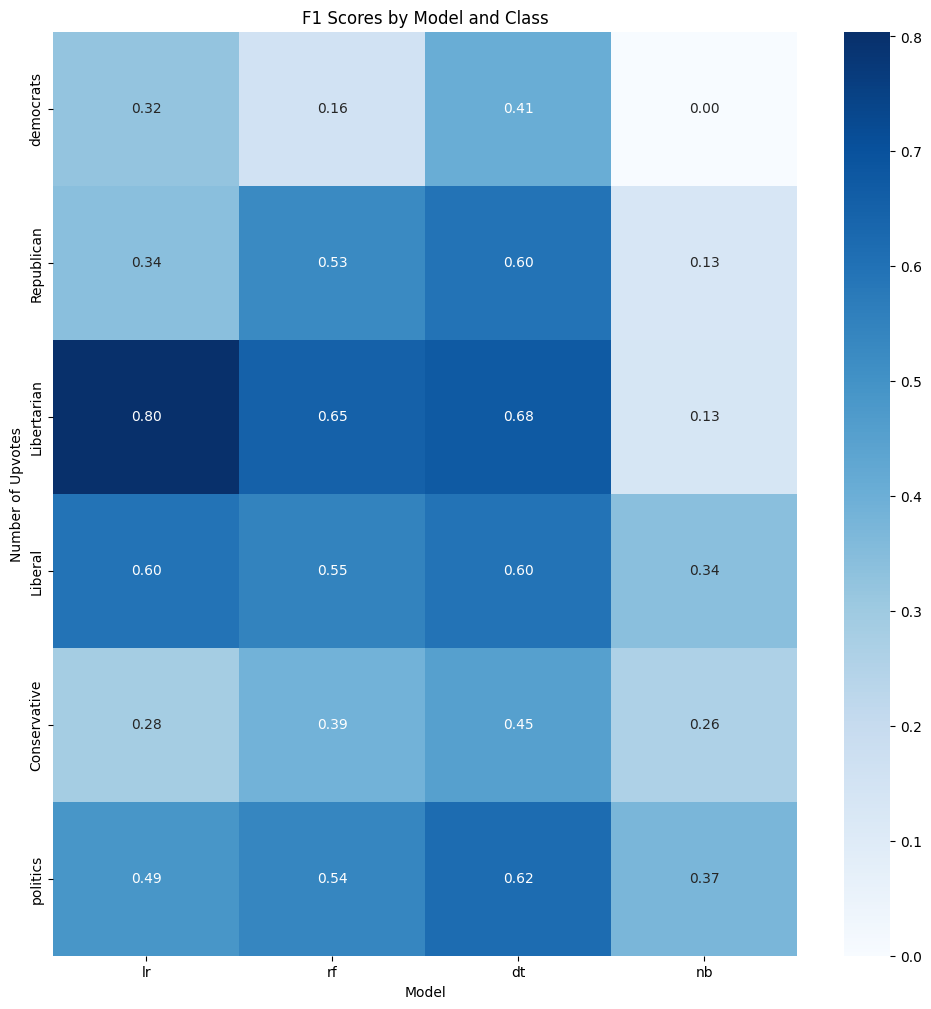

In [27]:
# Plot F1 scores
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.heatmap(f1_scores.astype(float), annot=True, ax=ax, cmap="Blues", fmt=".2f")

plt.title("F1 Scores by Model and Class")
plt.xlabel("Model")
plt.ylabel("Number of Upvotes")

# Reverse y-axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Get feature importances from decision tree model
dt_feature_importances = best_dt_model.featureImportances

# Get feature names
feature_names = pipeline_model.stages[-2].getInputCols()

print(len(feature_names), len(dt_feature_importances))

vocab = pipeline_model.stages[2].vocabulary
feature_list = vocab + feature_names

print(len(feature_list), len(dt_feature_importances))

In [ ]:
# Assuming `tfidf_cv` is one of the features
dt_feature_importances = best_dt_model.featureImportances.toArray()
count_vectorizer_model = pipeline_model.stages[2]
vocabulary = count_vectorizer_model.vocabulary

# Feature ranges for each column
feature_ranges = {}
start_index = 0
for col in feature_names:
    if col == "tfidf_cv":
        feature_ranges[col] = (start_index, start_index + len(vocabulary))
        start_index += len(vocabulary)
    else:
        feature_ranges[col] = (start_index, start_index + 1)
        start_index += 1

# Map vectorized features to vocabulary
feature_importance_data = []
for col, (start, end) in feature_ranges.items():
    if col == "tfidf_cv":
        tfidf_importances = dt_feature_importances[start:end]
        tfidf_df = pd.DataFrame(
            list(zip(vocabulary, tfidf_importances)),
            columns=["feature", "importance"]
        )
        tfidf_df["source"] = "tfidf_cv"
        feature_importance_data.append(tfidf_df)
    else:
        single_importance = dt_feature_importances[start:end][0]
        feature_importance_data.append(pd.DataFrame({
            "feature": [col],
            "importance": [single_importance],
            "source": [col]
        }))

# Combine all feature importance data
feature_importance_df = pd.concat(feature_importance_data)

In [238]:
feature_importance_df.to_csv("feature_importances.csv", index=False)
feature_importance_df

,feature,importance,source
0,,0.035757,tfidf_cv
1,trump,0.020258,tfidf_cv
2,biden,0.004792,tfidf_cv
3,president,0.001823,tfidf_cv
4,donald,0.001774,tfidf_cv
...,...,...,...
0,is_border,0.000000,is_border
0,is_war,0.000000,is_war
0,is_israel,0.003825,is_israel
0,is_harris,0.001094,is_harris


In [30]:
feature_importance_df = pd.read_csv("../../../data/models/subreddit-pred/results/feature_importances.csv")
feature_importance_df.sort_values("importance", ascending=False, inplace=True)

In [74]:
fi_head

,feature,importance,source,clean_names
1002,author_index,0.413424,author_index,Author
1000,num_comments,0.214217,num_comments,Number of Comments
1006,is_biden,0.067863,is_biden,Word: Biden
1001,score,0.053060,score,Score
49,libertarian,0.051756,tfidf_cv,Word: libertarian
1005,month,0.027883,month,Month posted
1,trump,0.020258,tfidf_cv,Word: Trump
257,military,0.005283,tfidf_cv,Word: military
1008,is_hunter,0.005146,is_hunter,Mentions Hunter Biden
2,biden,0.004792,tfidf_cv,Word: Biden


In [36]:
fi_head = feature_importance_df.head(20)

fi_head['clean_names'] = [
    'Author',
    'Number of Comments',
    'Word: Biden',
    'Score',
    'Word: libertarian',
    "",
    'Month posted',
    'Word: Trump',
    'Word: military',
    'Mentions Hunter Biden',
    'Word: Biden',
    'Mentions Israel',
    'Word: NATO',
    'Sentiment',
    'Word: immunity',
    'Word: fall',
    'Word: crowd',
    'Word: behind',
    'Word: AI',
    'Word: libertarians'
]

/var/folders/4w/gxhbpkhj19j6ydpft6pz0grc0000gn/T/ipykernel_72693/1810661382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_head['clean_names'] = [


In [37]:
fi_head = fi_head[fi_head['clean_names'] != ""]

# Sum up importances for each feature
feature_importance_sum = fi_head.groupby("clean_names")["importance"].sum().reset_index()
feature_importance_sum.sort_values("importance", ascending=False, inplace=True)
feature_importance_sum

,clean_names,importance
0,Author,0.413424
4,Number of Comments,0.214217
8,Word: Biden,0.072655
5,Score,0.053060
15,Word: libertarian,0.051756
3,Month posted,0.027883
10,Word: Trump,0.020258
17,Word: military,0.005283
1,Mentions Hunter Biden,0.005146
2,Mentions Israel,0.003825


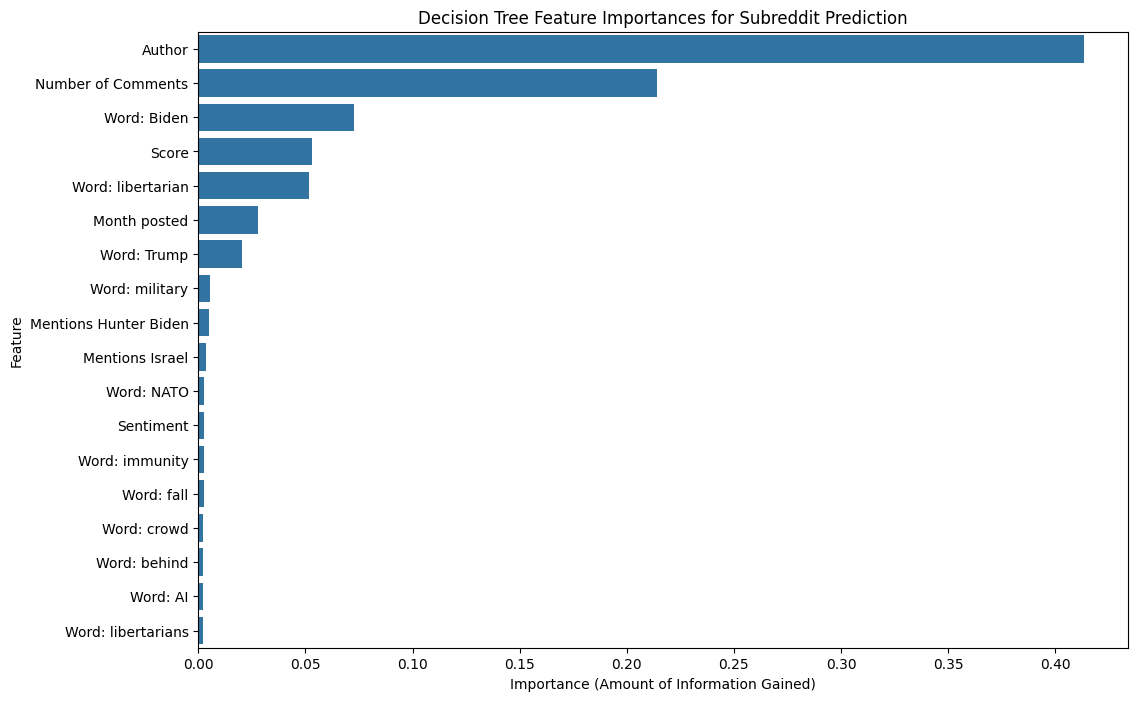

In [38]:
# Plot feature importances
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.barplot(data=feature_importance_sum, x="importance", y="clean_names", ax=ax)

plt.title("Decision Tree Feature Importances for Subreddit Prediction")
plt.xlabel("Importance (Amount of Information Gained)")
plt.ylabel("Feature")

plt.show()

# Save fig
fig.savefig("dt_feature_importances.png", bbox_inches="tight", dpi=300)

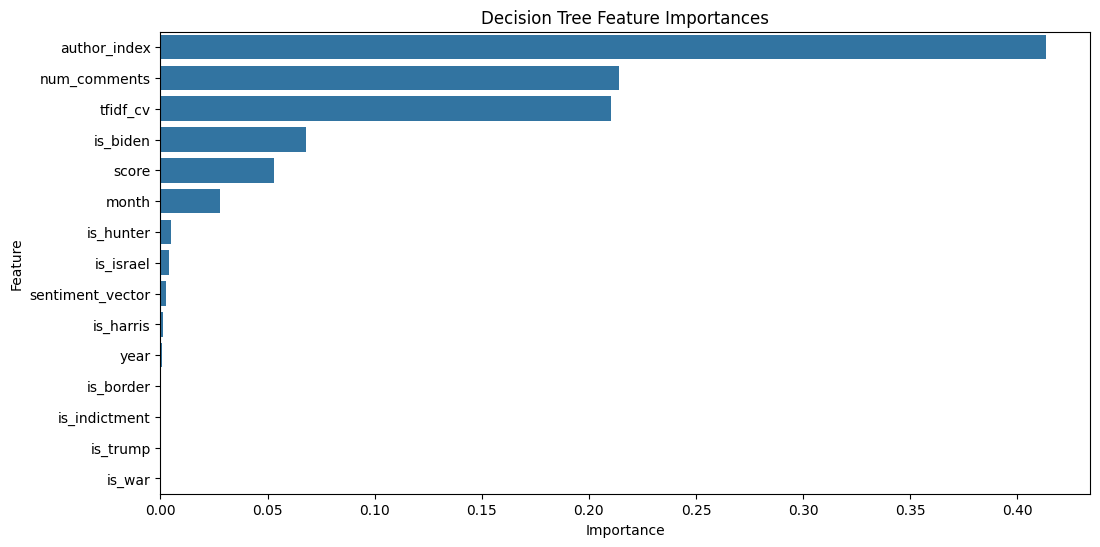

In [245]:
feature_importance_df = pd.read_csv("feature_importances.csv")
feature_importance_df = feature_importance_df.groupby("source").sum().reset_index()
feature_importance_df.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.barplot(data=feature_importance_df, x="importance", y="source", ax=ax)

plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.show()